# MNIST Clustering using Variational Autoencoder

In [6]:
#mathematics
using LinearAlgebra
using ForwardDiff

#datasets
using MLDatasets

#statistics
using Distributions
using Statistics
using Random
using StatsBase

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

#threads
using Base.Threads
nthreads()

4

In [14]:
#reshape images
function vecX(x)
    d1,d2,N = size(x)
    X = zeros(d1*d2, N)
    for n in 1:N
        X[:,n] = x[:,:,n][:]
    end
    return X
end

#get the train data
train_x, train_y = MNIST.traindata()
X = vecX(train_x)

#images whose labels are 0 or 1
idx0or1 = Bool.((train_y.==0) + (train_y.==1))
X = X[:,idx0or1]
Y = train_y[idx0or1]
X = X[:,1:1000]
Y = Y[1:1000]

#data
Dx, N = size(X)
data = (X=X, Dx=Dx, N=N)

(X = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Dx = 784, N = 1000)

In [8]:
#initialize the parameter
function init_params(st)
    @unpack  DI, DO, DM = st
    W₂ = randn(DM, DI)
    W₃ = randn(DO, DM)
    b₂ = zeros(DM)
    b₃ = zeros(DO)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  DI, DO, DM = st
    W = reshape(wvec, (DI+DO+1, DM+1))
    W₂ = view(W, 2:DI+1, 1:DM)'
    W₃ = view(W, DI+2:DI+DO+1, 1:DM)
    b₂ = view(W, 1, 1:DM)
    b₃ = view(W, DI+2:DI+DO+1, DM+1)
    return W₂, W₃, b₂, b₃
end 

#Neural Network
function nn(x, wvec, st)
   @unpack  DI, DO, DM = st
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return W₃*tanh.(W₂*x+b₂) + b₃
end

nn (generic function with 1 method)

In [16]:
#encoder and decoder
Φ(zn, wvec, stΦ) = nn(zn, wvec, stΦ)
Ψ(xn, ηvec, stΨ) = nn(xn, ηvec, stΨ)

#mean and logstd, std
function mean_and_logstd(vecn, pvec, D, st)
    tmp = nn(vecn, pvec, st)
    @inbounds tmp[1:D], tmp[D+1:end]
end

function mean_and_std(vecn, pvec, D, st)
    mvec, logsvec = mean_and_logstd(vecn, pvec, D, st)
    mvec, exp.(logsvec)
end

#used for reparameterization trick of zn
function h(ϵvec, ηvec, xn, Dz, stΨ)
    mvec, svec = mean_and_std(xn, ηvec, Dz, stΨ)
    mvec + svec .* ϵvec
end

#logpmodel
function logpmodel(xn, zn, wvec, stΦ)
    Dx = length(xn)
    mvec, svec = mean_and_std(zn, wvec, Dx, stΦ)
    logpdf(MvNormal(mvec, svec), xn)
end
logpmodel(xn, ηvec, wvec, ϵvec, Dz, stΦ, stΨ) = logpmodel(xn, h(ϵvec, ηvec, xn, Dz, stΨ), wvec, stΦ)

#used for calculation of ELBO
function f(xn, ηvec, Dz, stΨ)
    mvec, logsvec = mean_and_logstd(xn, ηvec, Dz, stΨ)
    Dz/2 + sum(logsvec) - norm(mvec)^2/2 - norm(exp.(logsvec))^2/2
end

#ELBO L
function ELBO(X, ηvec, wvec, ϵsamps, N, Dz, S, stΦ, stΨ)
    logpmodels = zeros(S)
    sumvec = zeros(N)
    for n in 1:N
        for s in 1:S
            @inbounds logpmodels[s] = logpmodel(X[:,n], ηvec, wvec, ϵsamps[s], Dz, stΦ, stΨ)
        end
        @inbounds sumvec[n] = mean(logpmodels) + f(X[:,n], ηvec, Dz, stΨ)
    end
    sum(sumvec)
end

#approximatio of ELBO Ln
ELBOn(xn,ηvec,wvec,ϵvec,Dz,stΦ,stΨ) = logpmodel(xn,ηvec,wvec,ϵvec,Dz,stΦ,stΨ) + f(xn,ηvec,Dz,stΨ)

#gradient of ELBO w.r.t w and η
∇wLn_samp(xm,wvec,ηvec,ϵsamp,Dz,stΦ,stΨ) = (
    ForwardDiff.gradient(vec->ELBOn(xm,ηvec,vec,ϵsamp,Dz,stΦ,stΨ), wvec)
)
function ∇wLn(minibatch, minibatch_size, N, ηvec, wvec, ϵsamp, Dz, stΦ, stΨ)
    ∇wLnvec = zeros(dw, minibatch_size)
    @threads for m in 1:minibatch_size
        @inbounds ∇wLnvec[:,m] = ∇wLn_samp(minibatch[:,m],wvec,ηvec,ϵsamp,Dz,stΦ,stΨ)
    end
    N*mean(∇wLnvec, dims=2)
end

∇ηLn_samp(xm,wvec,ηvec,ϵsamp,Dz,stΦ,stΨ) = (
    ForwardDiff.gradient(vec->ELBOn(xm,vec,wvec,ϵsamp,Dz,stΦ,stΨ), ηvec)
)
function ∇ηLn(minibatch, minibatch_size, N, ηvec, wvec, ϵsamp, Dz, stΦ, stΨ)
    ∇ηLnvec = zeros(dη, minibatch_size)
    @threads for m in 1:minibatch_size
        @inbounds ∇ηLnvec[:,m] =  ∇ηLn_samp(minibatch[:,m],wvec,ηvec,ϵsamp,Dz,stΦ,stΨ)
    end
    N*mean(∇ηLnvec, dims=2)
end    

#variational infernce
function myVI(data, model_params, n_train, minibatch_size, α)
    #initalize and set the parameters
    @unpack X,Dx,N = data
    @unpack dw,dη,Dz,stΦ,stΨ,wvec₀,ηvec₀ = model_params
    wvec = wvec₀
    ηvec = ηvec₀
    
    #minibatch
    minibatch = zeros(Dx,minibatch_size)
    
    #ELBO interval
    Δ = 50
    
    #AdaGrad
    δ = 1e-7
    gwvec = zeros(dw)
    gηvec = zeros(dη)
    rwvec = δ * ones(dw)
    rηvec = δ * ones(dη)
    
    #ELBO
    S = 100
    ϵsamp = rand(MvNormal(zeros(Dz), ones(Dz)))
    ϵsamps = rand(MvNormal(zeros(Dz), ones(Dz)), S)
    history = zeros(div(n_train, Δ))
    @inbounds @showprogress for k in 2:n_train
        #choose mini batch
        minibatch = X[:,sample(1:N, minibatch_size, replace=false)]
        
        #update(AdaGrad)
        ϵsamp = rand(MvNormal(zeros(Dz), ones(Dz)))
        gwvec = ∇wLn(minibatch, minibatch_size, N, ηvec, wvec, ϵsamp, Dz, stΦ, stΨ)
        gηvec = ∇ηLn(minibatch, minibatch_size, N, ηvec, wvec, ϵsamp, Dz, stΦ, stΨ)
        rwvec = rwvec + gwvec .* gwvec
        rηvec = rηvec + gηvec .* gηvec
        wvec += α * gwvec ./ sqrt.(rwvec)
        ηvec += α * gηvec ./ sqrt.(rηvec)
        
        #calculate ELBO
        if k%Δ == 0
            ϵsamps = rand(MvNormal(zeros(Dz), ones(Dz)), S)
            history[div(k,Δ)] = ELBO(X, ηvec, wvec, ϵsamps, N, Dz, S, stΦ, stΨ)
        end
    end
    return wvec, ηvec, history
end

myVI (generic function with 1 method)

In [17]:
#set the random seed
Random.seed!(42)

#latent dimension
Dz = 2

#initialize Neural Network (decoder)
DΦ = 10
stΦ = (DI=Dz, DO=2*Dx, DM=DΦ)
WΦ₂, WΦ₃, bΦ₂, bΦ₃ = init_params(stΦ)
WΦs = stick_params(WΦ₂, WΦ₃, bΦ₂, bΦ₃, stΦ.DI)
wvec₀ = WΦs[:]
dw = length(wvec₀)

#initialize Neural Network (encoder)
DΨ = 10
stΨ = (DI=Dx, DO=2*Dz, DM=DΨ)
WΨ₂, WΨ₃, bΨ₂, bΨ₃ = init_params(stΨ)
WΨs = stick_params(WΨ₂, WΨ₃, bΨ₂, bΨ₃, stΨ.DI)
ηvec₀ = WΨs[:]
dη = length(ηvec₀)

#model parameters
model_params = (dw=dw, dη=dη, Dz=Dz, stΦ=stΦ, stΨ=stΨ, wvec₀=wvec₀, ηvec₀=ηvec₀)

#variational inference
n_train = 500
α = 0.1
minibatch_size = 10
@time wvec, ηvec, history = myVI(data, model_params, n_train, minibatch_size, α)

Progress: 100%|█████████████████████████████████████████| Time: 1:58:25


7105.648663 seconds (599.42 M allocations: 8.191 TiB, 63.28% gc time, 0.03% compilation time)


([-0.10105076261714044; -0.4469777858544586; … ; 0.5064611983088959; 0.37322768963214104], [0.15163695500149071; -0.6400463139999073; … ; -0.21141895070972386; -0.08077365647809709], [-2.0546218833406727e9, -4.817587851733878e9, -2.0884602294278753e8, -1.607458316597062e8, -1.295648699770371e8, -1.1612039017517623e8, -1.0361625170882961e8, -1.0902977153497255e8, -1.0175131096272556e8, -8.42728397795859e7])

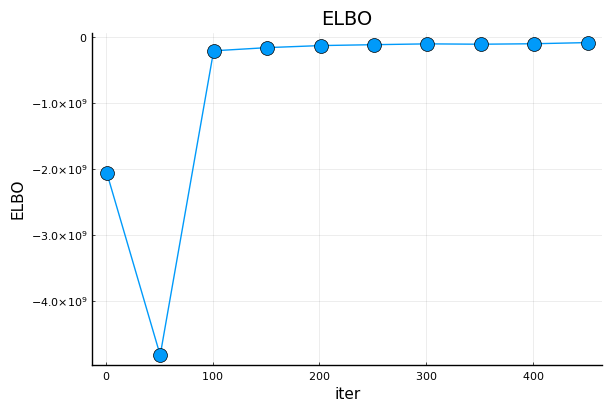

In [37]:
fig1 = plot(1:50:500, history, label=false, marker=:circle, markersize=10, markerstrokewidth=0.5, 
    title="ELBO", xlabel="iter", ylabel="ELBO")
savefig(fig1, "figs-VAE/fig1.png")

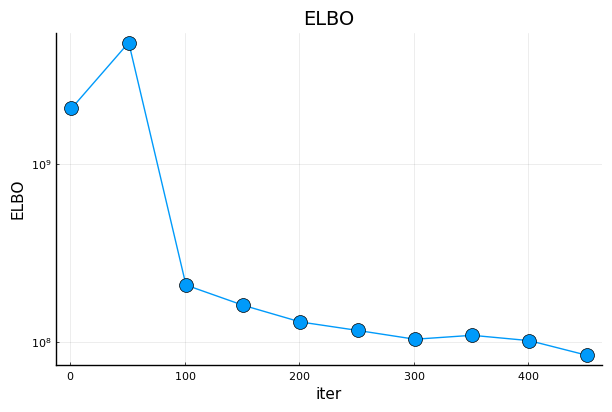

In [39]:
fig2 = plot(1:50:500, abs.(history), label=false, marker=:circle, markersize=10, markerstrokewidth=0.5, 
    yscale=:log10, title="ELBO", xlabel="iter", ylabel="ELBO")
savefig(fig2, "figs-VAE/fig2.png")

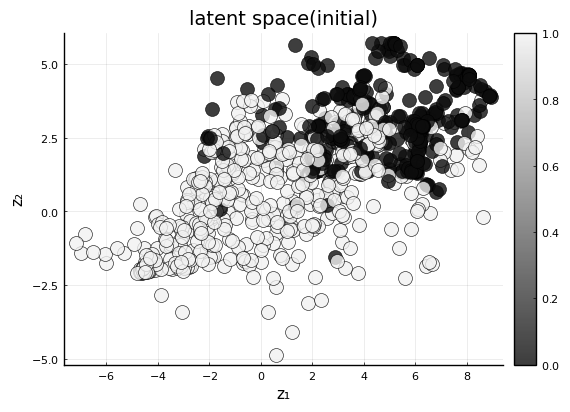

In [46]:
Zs = zeros(Dz, N)
for n in 1:N
    Zs[:,n] = Ψ(X[:,n], ηvec₀, stΨ)[1:Dz]
end
fig3 = plot(Zs[1,:],Zs[2,:],st=:scatter,zcolor=Y,markersize=10,
    c=palette(:grays),label=false,markerstrokewidth=0.5,alpha=0.8, xlabel="z₁", ylabel="z₂", title="latent space(initial)")
savefig(fig3, "figs-VAE/fig3.png")

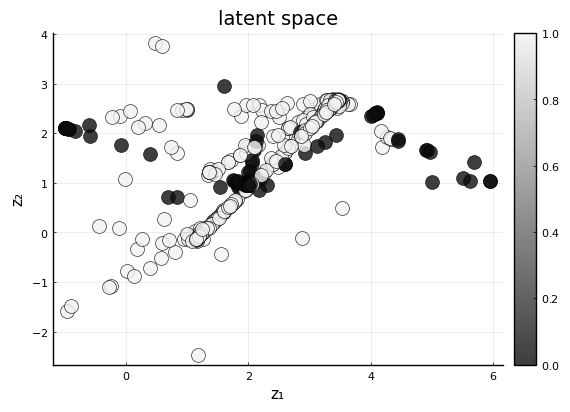

In [48]:
Zs = zeros(Dz, N)
for n in 1:N
    Zs[:,n] = Ψ(X[:,n], ηvec, stΨ)[1:Dz]
end
fig4=plot(Zs[1,:],Zs[2,:],st=:scatter,zcolor=Y,markersize=10,c=palette(:grays),
    label=false,markerstrokewidth=0.5,alpha=0.8, xlabel="z₁", ylabel="z₂", title="latent space")
savefig(fig4, "figs-VAE/fig4.png")